# 2. Evaluation und Adversarielle Robustheit (FGSM)

## 2.1 Vorbereitungen

In [1]:
# --- Datensatz und Modell Laden

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --- Pfade, Modellwahl, Run auswählen

import os
import pandas as pd
from glob import glob
from datetime import datetime
import matplotlib.pyplot as plt
import json

# eigene importe
from data import get_cifar10_loaders, show_first_images
from train_eval import load_history_csv, test_final, test_fgsm
from plots import plot_training_curves, get_predictions, plot_confidence_hist, plot_confusion_matrix

from models.lenet import LeNet5_CIFAR10
from models.vgg16 import VGG16_CIFAR10_BN
from models.resnet34 import ResNet34_CIFAR10

#REPO_DRIVE_DIR = "/content/drive/MyDrive/Bachelorarbeit-CIFAR10"
ARTIFACTS_DIR = os.path.join("./artifacts")


PLOT_DIR   = os.path.join(ARTIFACTS_DIR, "plots")
os.makedirs(PLOT_DIR, exist_ok=True)

RESULT_DIR   = os.path.join(ARTIFACTS_DIR, "results")
os.makedirs(RESULT_DIR, exist_ok=True)

Device: cuda


In [2]:

# DataLoader (nur Test reicht; du kannst deine data.py nutzen)

CLASSES = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')
EPSILONS = [1/255, 2/255, 4/255, 8/255]

DATA_DIR = "./content/data"

_, _, test_loader = get_cifar10_loaders(
    root=DATA_DIR,
    batch_size=64,
    num_workers=0,
    val_ratio=0.1,
    seed=42
)

# Dataset für Visualisierung
test_dataset = test_loader.dataset

print("Test batches", len(test_loader))

Files already downloaded and verified
Files already downloaded and verified
Test batches 157


/home/katharina/projects/jupyter/.venv/lib/python3.13/site-packages/torchvision/transforms/functional.py:63: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


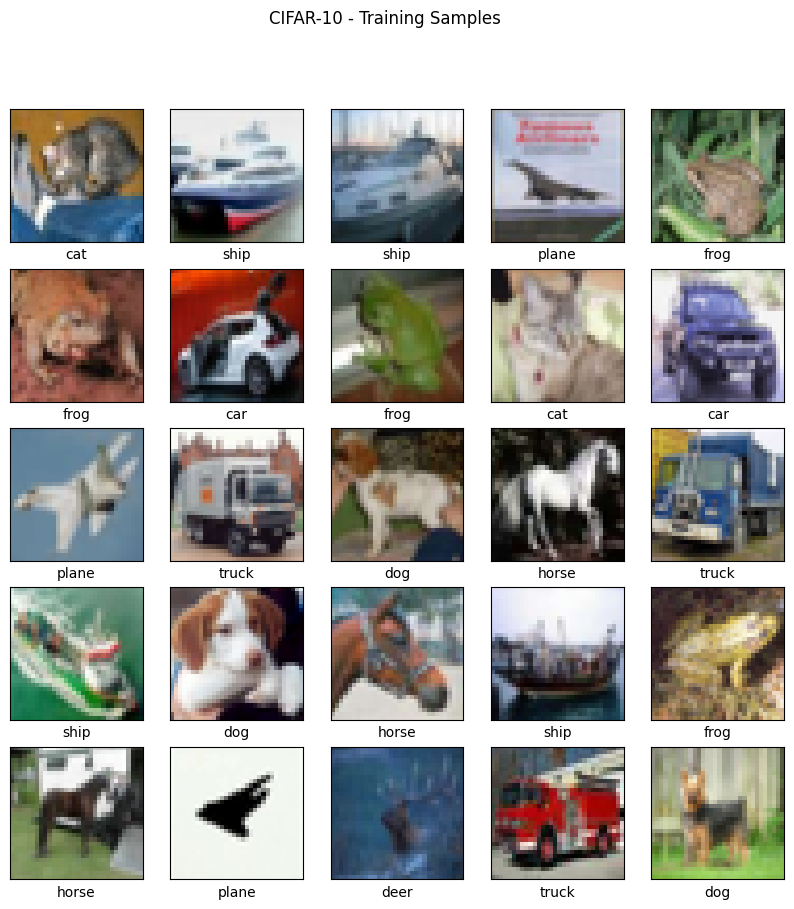

In [3]:
fig = show_first_images(test_dataset, CLASSES, n=25, title="CIFAR-10 - Training Samples")
fig.savefig(os.path.join(PLOT_DIR, "cifar10_first_images.png"), dpi=300, bbox_inches="tight")
plt.show()

## 2.2 VGG16 Auswertung

### Laden des trainierten Modells

In [6]:
RUNS_DIR   = os.path.join(ARTIFACTS_DIR, "runs/vgg16_25ep_20260114_141539")
MODEL_PATH  = os.path.join(RUNS_DIR, "checkpoints/vgg16_25ep_best.pt" )
CSV_PATH = os.path.join(RUNS_DIR, "vgg16_25ep_metrics.csv" )


model_name = "vgg16"   # "lenet5" | "vgg16" | "resnet34"
print(MODEL_PATH)

./artifacts/runs/vgg16_25ep_20260114_141539/checkpoints/vgg16_25ep_best.pt


In [7]:
# --- Metrics laden
df = pd.read_csv(CSV_PATH)
display(df.tail())


,epoch,train_loss,val_loss,val_acc,lr,epoch_time_sec,gpu_peak_mem_mb
20,21,0.025619,0.566482,87.42,0.00010,120.053212,409.697754
21,22,0.017519,0.591460,87.34,0.00010,120.491607,409.697754
22,23,0.015419,0.643976,87.24,0.00010,117.733892,409.697754
23,24,0.011936,0.656449,87.06,0.00010,147.275169,409.697754
24,25,0.010018,0.655865,87.36,0.00001,117.551394,409.697754


In [8]:
# --- Lade history CSV
history_loaded = load_history_csv(CSV_PATH)

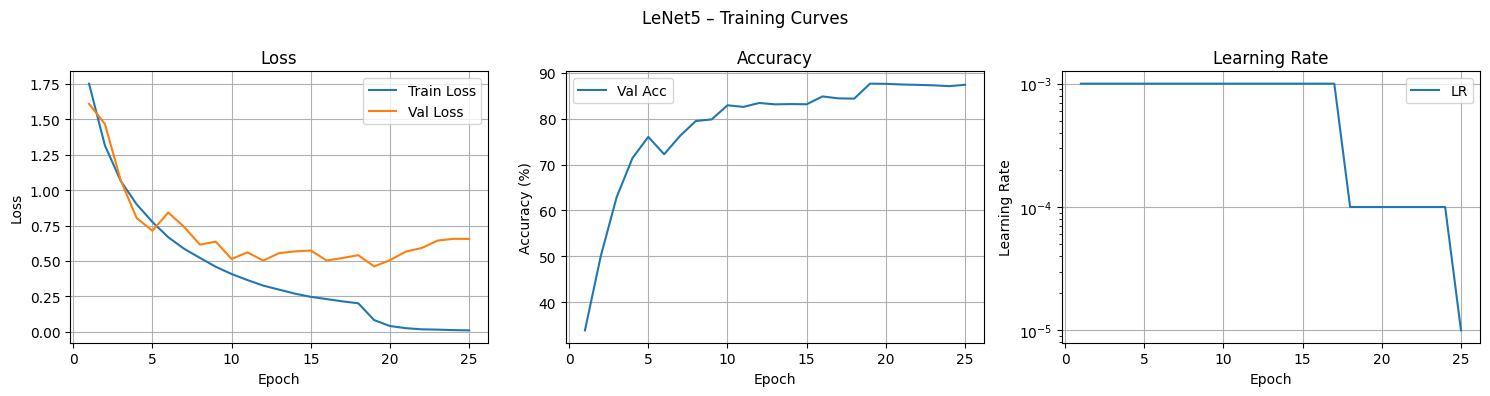

In [9]:
# --- History im Format der Plot-Funktion bauen und speichern
fig = plot_training_curves(history_loaded, title=f"LeNet5 – Training Curves")
fig.savefig(os.path.join(PLOT_DIR, f"{model_name}_curves.png"), dpi=300, bbox_inches="tight")
plt.show()

### Evaluation auf dem sauberen Testdatensatz

In [11]:
# --- Evaluation des Models
model = VGG16_CIFAR10_BN().to(device)

ckpt = torch.load(MODEL_PATH, map_location=device, weights_only=True)
print(type(ckpt))
print(ckpt.keys())

model.load_state_dict(ckpt["model_state"])  # oder ckpt["state_dict"], je nach deinem Code
model.eval()

<class 'dict'>
dict_keys(['epoch', 'model_state', 'opt_state', 'sched_state', 'best_val_loss', 'bad_epochs'])


VGG16_CIFAR10_BN(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5

In [12]:
# --- clean test ---
clean_loss, clean_acc = test_final(model, test_loader, device=device)

[CLEAN TEST] loss=0.4895 | acc=86.86%


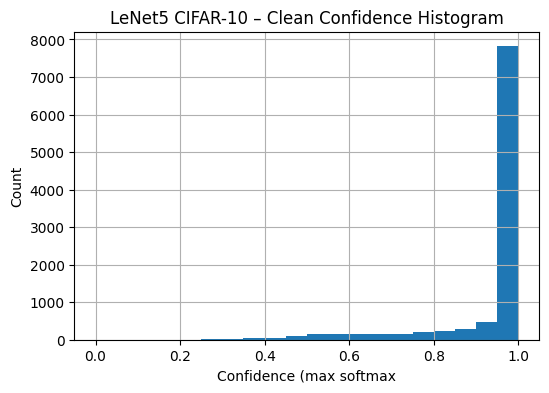

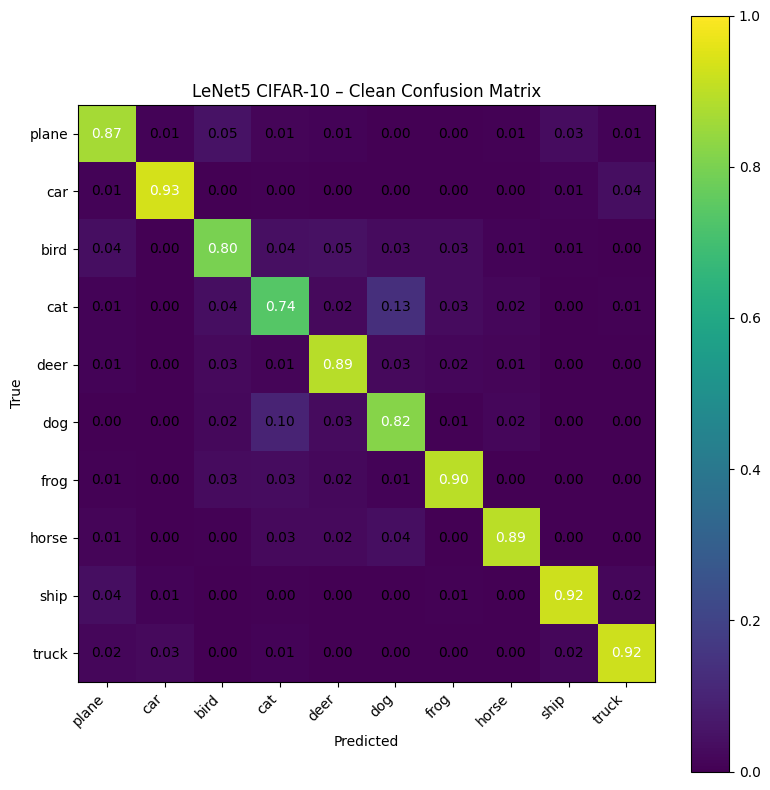

In [13]:
# --- Clean predictions (for plots) 
preds, labels, probs = get_predictions(model, test_loader, device)

# --- Clean Confidence Histogram (max softmax) 
fig = plot_confidence_hist(probs, title="LeNet5 CIFAR-10 – Clean Confidence Histogram")
fig.savefig(os.path.join(PLOT_DIR, f"{model_name}_confidence.png"), dpi=300, bbox_inches="tight")
plt.show()

# --- Clean Confusion Matrix 
fig = plot_confusion_matrix(preds, labels, CLASSES, title="LeNet5 CIFAR-10 – Clean Confusion Matrix")
fig.savefig(os.path.join(PLOT_DIR, f"{model_name}_confusion.png"), dpi=300, bbox_inches="tight")
plt.show()


### FGSM-Angriff 

In [14]:
# --- FGSM table (all eps) ---

fgsm_rows = []
for eps in EPSILONS:
    adv_loss, adv_acc = test_fgsm(model, test_loader, device=device, epsilon=eps)
    drop = clean_acc - adv_acc
    fgsm_rows.append({
        "epsilon": float(eps),
        "adv_loss": float(adv_loss),
        "adv_acc": float(adv_acc),
        "acc_drop": float(drop)
    })
    print(f"[FGSM] eps={eps:.5f} | loss={adv_loss:.4f} | acc={adv_acc:.2f}% | drop={drop:.2f}pp")


# Save results
out = {
    "model": model_name,
    "clean_loss": float(clean_loss),
    "clean_acc": float(clean_acc),
    "epsilons": [float(e) for e in EPSILONS],
    "fgsm": fgsm_rows
}

with open(os.path.join(RESULT_DIR, f"{model_name}_fgsm_results.json"), "w") as f:
    json.dump(out, f, indent=2)

[FGSM] eps=0.00392 | loss=0.9999 | acc=76.41% | drop=10.45pp
[FGSM] eps=0.00784 | loss=1.6346 | acc=66.10% | drop=20.76pp
[FGSM] eps=0.01569 | loss=2.9689 | acc=47.87% | drop=38.99pp
[FGSM] eps=0.03137 | loss=5.0338 | acc=27.28% | drop=59.58pp


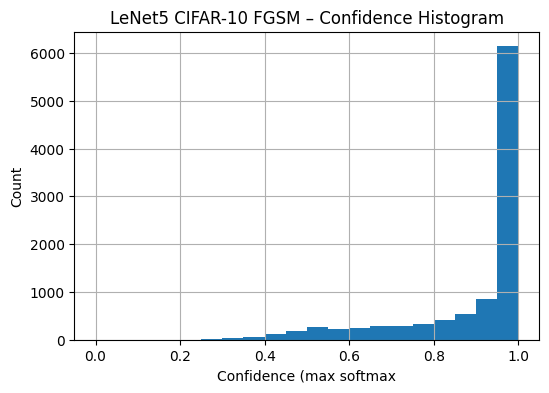

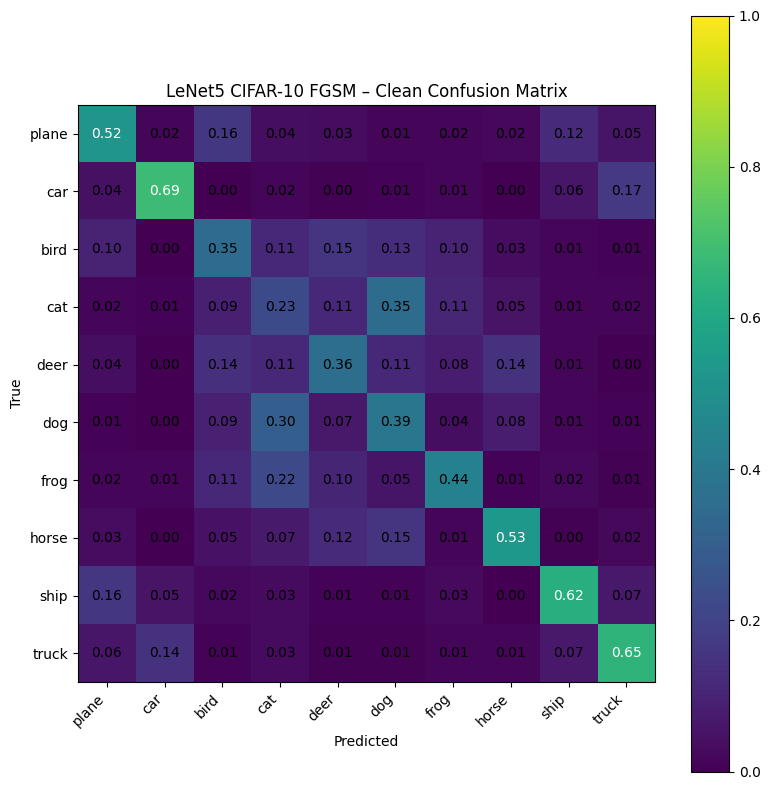

In [15]:
# --- FGSM plots for ONE representative epsilon ---

EPS = 4/255
preds_adv, labels_adv, probs_adv = get_predictions(
    model, test_loader, device, attack=True, epsilon=EPS
)


# --- FGSM Confidence Histogram (max softmax) ---

fig = plot_confidence_hist(probs_adv, title="LeNet5 CIFAR-10 FGSM – Confidence Histogram")
fig.savefig(os.path.join(PLOT_DIR, f"{model_name}_fgsm_confidence.png"), dpi=300, bbox_inches="tight")
plt.show()

# --- FGSM Confusion Matrix ---
fig = plot_confusion_matrix(preds_adv, labels, CLASSES, title="LeNet5 CIFAR-10 FGSM – Clean Confusion Matrix")
fig.savefig(os.path.join(PLOT_DIR, f"{model_name}_fgsm_confusion.png"), dpi=300, bbox_inches="tight")
plt.show()


## VGG16